# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>



Ouissal, Salima, Alexandre, Idriss, Elias

## Modules

In [79]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
import pandas as pd
import random
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Module csv
import csv

## Préprocessing des données

Pour la suite de notre étude, on considère le modèle d'avion **Airbus A320**, qui dispose de **174** sièges. (La classe businees n'est pas prise en compte)


<img src="modele_avion.jpg" alt="Modèle de l'avion" width="400" height="600">

In [80]:
# Load the Excel file into a pandas DataFrame

df_21Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [81]:
# On choisit la df sur laquelle on va travailler

df = df_21Oct
# df = df_22Oct
# df = df_23Oct
# df = df_24Oct
# df = df_30Oct
# df = df_05Nov
# df = df_07Nov

In [82]:
# Groups : dict[int : List[int]]

Passagers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0
transit_times= set()
for group in df.itertuples():
    for j in range(2,5):
        if not pd.isna(group[j]):
            for k in range(int(group[j])):
                transit_time = group[5].hour*60 + group[5].minute
                Passagers[i] = {'gender': j-2, 'group': group[1], 'transit': float('inf')}
                if transit_time != 0 and transit_time < 121:
                    Passagers[i]['transit'] = transit_time
                    transit_times.add(transit_time)  # Add to the list, keeping duplicates if any
                if j == 2: number_f+=1
                elif j==3: number_m+=1
                else: number_d+=1

                i+=1    

Passagers

{1: {'gender': 1, 'group': 1, 'transit': 75},
 2: {'gender': 0, 'group': 2, 'transit': inf},
 3: {'gender': 1, 'group': 3, 'transit': inf},
 4: {'gender': 0, 'group': 4, 'transit': inf},
 5: {'gender': 1, 'group': 5, 'transit': inf},
 6: {'gender': 1, 'group': 5, 'transit': inf},
 7: {'gender': 0, 'group': 6, 'transit': inf},
 8: {'gender': 0, 'group': 7, 'transit': inf},
 9: {'gender': 0, 'group': 8, 'transit': 80},
 10: {'gender': 1, 'group': 8, 'transit': 80},
 11: {'gender': 1, 'group': 9, 'transit': inf},
 12: {'gender': 0, 'group': 10, 'transit': inf},
 13: {'gender': 0, 'group': 11, 'transit': inf},
 14: {'gender': 1, 'group': 11, 'transit': inf},
 15: {'gender': 1, 'group': 12, 'transit': 70},
 16: {'gender': 1, 'group': 13, 'transit': inf},
 17: {'gender': 0, 'group': 14, 'transit': inf},
 18: {'gender': 1, 'group': 14, 'transit': inf},
 19: {'gender': 1, 'group': 15, 'transit': inf},
 20: {'gender': 1, 'group': 16, 'transit': 95},
 21: {'gender': 0, 'group': 17, 'transit': 60

In [83]:
Groups = dict()

for i, passager in Passagers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]
for i in range(1,len(df)+1):
    if len(Groups[i]) ==1: del(Groups[i])
Groups

{5: [5, 6],
 8: [9, 10],
 11: [13, 14],
 14: [17, 18],
 17: [21, 22],
 19: [24, 25, 26, 27],
 20: [28, 29, 30, 31],
 21: [32, 33],
 23: [35, 36],
 24: [37, 38],
 27: [41, 42],
 31: [46, 47],
 34: [50, 51],
 35: [52, 53],
 39: [57, 58],
 45: [64, 65],
 51: [71, 72],
 55: [76, 77],
 56: [78, 79],
 57: [80, 81],
 59: [83, 84],
 61: [86, 87],
 63: [89, 90],
 65: [92, 93, 94],
 68: [97, 98],
 71: [101, 102],
 77: [108, 109],
 87: [119, 120],
 92: [125, 126],
 95: [129, 130],
 103: [138, 139],
 104: [140, 141],
 108: [145, 146],
 109: [147, 148],
 110: [149, 150]}

In [84]:
# Number of rows and columns per row based on the airplane configuration
number_of_seats = 174
number_of_rows = 29  # Rows are 1-indexed from 1 to 29
seats_per_row = 6    # 6 seats per row (0,1,2,3,4,5)
number_of_seats = 174
number_of_columns=seats_per_row
weight_f = 70 # weight female
weight_m = 85 # weight male
weight_d = 92.5 # weight disabled

## Initialize the model

In [85]:
m = Model("airplane_seating")

# Weights is a dictionary mapping (i, j, k) to a weight, as discussed earlier

# Create decision variables for each seat and passenger
# The decision variable x will be a 3D dictionary with the keys being the row number,
# the seat within the row, and the unique identifier for each passenger.

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, seats_per_row + 1)
                    for k in range(1, len(Passagers)+1)}


In [86]:
# # Create AdjacentVarDict only for pairs of passengers in the same group and not the same person
# AdjacentVarDict = {
#     (i1, j1, k1, k2): m.addVar(vtype=GRB.BINARY, name=f'adjacent_{i1}{j1}{k1}_{k2}')
#     for i1 in range(1, number_of_rows + 1)
#     for j1 in range(1, seats_per_row + 1)
#     for k1 in Passagers.keys()
#     for k2 in Passagers.keys()
#     if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2
# }

## Constraints

In [87]:
# Each passenger has a seat
SEATSASSIGNMENTCONST = m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                             for i in range(1, number_of_rows + 1)
                                             for j in range(1, seats_per_row + 1)
                                             for k in range(1,len(Passagers)+1)]) == len(Passagers))


In [88]:
# Each passenger must have one seat
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, seats_per_row + 1) ]) == 1)
                                                for k in range(1,len(Passagers)+1) }


In [89]:
# # Every seat is allocated to a single passenger
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passagers)+1)])<=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, seats_per_row+1)  }

In [90]:
# Constraint Airplane Centrage

i_m = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])
i_f = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])
i_d = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

i_bary = (i_m + i_f +i_d)/( weight_m * number_m + weight_f * number_f + weight_d * number_d)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])
j_f = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])
j_d = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

j_bary = (j_m + j_f + j_d)/( weight_m * number_m + weight_f * number_f + weight_d * number_d)

IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 4)
JMINBARYCONST = m.addConstr(3 <= j_bary)

In [91]:
# # Constraints for the Disabled to be placed in front and in a certain way
# DISABLEDCONSTR = m.addConstr(quicksum( [AssignmenVarDict[(i, j, k)] + AssignmenVarDict[(i, j-1, k)] + AssignmenVarDict[(i+1, j-1, k)] + AssignmenVarDict[(i+1, j, k)]
#                       for i in range(1, number_of_rows)
#                       for j in range(2, seats_per_row+1 )
#                       for k in range(1, len(Passagers)+1)
#                       if Passagers[k]['gender'] == 2 ])<=1)

# Linearisation ( variables + contraintes)

In [93]:
# Ajout des variables auxiliaires pour les passager i+1 i-1

AuxVarDict1 = {(i1, j1, k1, k2): m.addVar(vtype=GRB.BINARY, name=f"AuxVar_{i1}_{j1}_{k1}_{k2}") 
                for i1 in range(1, number_of_rows + 1) 
                for j1 in range(1, number_of_columns + 1) 
                for k1 in Passagers.keys()
                for k2 in Passagers.keys()
                if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2
            }

        

# Ajout des contraintes pour linéariser les produits i+1 i-1
for i1 in range(1, number_of_rows + 1):
    for j1 in range(1, number_of_columns + 1):
        for k1 in Passagers.keys():
            for k2 in Passagers.keys():
                if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2:
                    # m.addConstr(AuxVarDict1[(i1, j1, k1, k2)] >= AssignmenVarDict.get((i1, j1, k1), 0) + AssignmenVarDict.get((i1 + 1, j1, k2), 0) - 1)
                    m.addConstr(AuxVarDict1[(i1, j1, k1, k2)] <= AssignmenVarDict.get((i1, j1, k1), 0))
                    m.addConstr(AuxVarDict1[(i1, j1, k1, k2)] <= AssignmenVarDict.get((i1 + 1, j1, k2), 0)+AssignmenVarDict.get((i1 - 1, j1, k2), 0))




# Ajout des variables auxiliaires pour les passager j+1 j-1


AuxVarDict2 = {(i1, j1, k1, k2): m.addVar(vtype=GRB.BINARY, name=f"AuxVar_{i1}_{j1}_{k1}_{k2}") 
                for i1 in range(1, number_of_rows + 1) 
                for j1 in range(1, number_of_columns + 1) 
                for k1 in Passagers.keys()
                for k2 in Passagers.keys()
                if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2
            }

            
        
# Ajout des contraintes pour linéariser les produits j+1 j-1
for i1 in range(1, number_of_rows + 1):
    for j1 in range(1, number_of_columns + 1):
        for k1 in Passagers.keys():
            for k2 in Passagers.keys():
                if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2:
                    # m.addConstr(AuxVarDict2[(i1, j1, k1, k2)] >= AssignmenVarDict.get((i1, j1, k1), 0) + AssignmenVarDict.get((i1, j1+1, k2), 0) - 1)
                    m.addConstr(AuxVarDict2[(i1, j1, k1, k2)] <= AssignmenVarDict.get((i1, j1, k1), 0))
                    m.addConstr(AuxVarDict2[(i1, j1, k1, k2)] <= AssignmenVarDict.get((i1, j1+1, k2), 0)+AssignmenVarDict.get((i1, j1-1, k2), 0))
                    





## Objective Function

Nonlinéaire

In [94]:
# b=0.4
# a=0.1
# objective_groups = quicksum(
#     a * AssignmenVarDict.get((i1, j1, k1), 0) * AssignmenVarDict.get((i1 + 1, j1, k2), 0) +
#     a * AssignmenVarDict.get((i1, j1, k1), 0) * AssignmenVarDict.get((i1 - 1, j1, k2), 0) +
#     b * AssignmenVarDict.get((i1, j1, k1), 0) * AssignmenVarDict.get((i1, j1 + 1, k2), 0) +
#     b * AssignmenVarDict.get((i1, j1, k1), 0) * AssignmenVarDict.get((i1, j1 - 1, k2), 0)
#     for i1 in range(1, number_of_rows + 1)
#     for j1 in range(1, number_of_columns + 1)
#     for k1 in Passagers.keys()
#     for k2 in Passagers.keys()
#     if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2
# )

# # Définition de l'objectif à maximiser
# m.setObjective(objective_groups, GRB.MAXIMIZE)


Linéaire factorisé

In [96]:
b=0.8 # poids pour  rang 
a=0.2 # poids pour  colonne 

objective_groups = sum(
    a*AuxVarDict1[(i1, j1, k1, k2)] + b*AuxVarDict2[(i1, j1, k1, k2)]
    for i1 in range(1, number_of_rows + 1)
    for j1 in range(1, number_of_columns + 1)
    for k1 in Passagers.keys()
    for k2 in Passagers.keys()
    if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2
)
m.setObjective(objective_groups, GRB.MAXIMIZE)


## Optimize Model

In [97]:
# Run optimization and suppress output
# m.Params.TimeLimit = 

# Définir PreQLinearize à 1 pour activer la linéarisation des termes quadratiques ( pas besoin ici déja linéaire)
# m.Params.PreQLinearize = 1

m.update()
m.optimize()


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.0.0 23A344)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 65754 rows, 58986 columns and 340898 nonzeros
Model fingerprint: 0x36f53085
Variable types: 0 continuous, 58986 integer (58986 binary)
Coefficient statistics:
  Matrix range     [7e-03, 1e+00]
  Objective range  [2e-01, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.31s
Presolved: 65753 rows, 58986 columns, 304054 nonzeros
Variable types: 0 continuous, 58986 integer (58986 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 9.400000e+01, 12746 iterations, 0.29 seconds (0.43 work units)

    Nodes    |  

## Graphic Seating Arrangement

In [98]:
seating_arrangement = {}
for i in range(1, number_of_rows + 1):
    for j in range(1, seats_per_row + 1):
        for k in Passagers.keys():
            if AssignmenVarDict[(i, j, k)].X > 0.5:  # Ensure the variable is part of the solution
                seating_arrangement[(i, j)] = k
print(f"Seating arrangement: {seating_arrangement}")
print(f'Optimal objective value (z*): {round(m.objVal, 2)}')

Seating arrangement: {(1, 1): 130, (1, 2): 129, (1, 4): 52, (1, 5): 53, (1, 6): 56, (2, 1): 106, (2, 2): 30, (2, 3): 31, (2, 4): 29, (2, 5): 28, (3, 1): 44, (3, 3): 144, (3, 5): 78, (3, 6): 79, (4, 1): 147, (4, 2): 148, (4, 3): 26, (4, 4): 24, (4, 5): 27, (4, 6): 25, (5, 1): 16, (5, 2): 97, (5, 3): 98, (5, 4): 7, (5, 5): 109, (5, 6): 108, (6, 1): 102, (6, 2): 101, (6, 3): 63, (6, 4): 143, (6, 5): 38, (6, 6): 37, (7, 1): 60, (7, 2): 42, (7, 3): 41, (7, 4): 110, (7, 6): 34, (8, 1): 133, (8, 2): 69, (8, 3): 64, (8, 4): 65, (8, 5): 49, (8, 6): 3, (9, 1): 115, (9, 2): 15, (9, 3): 95, (9, 4): 113, (9, 5): 135, (9, 6): 8, (10, 1): 39, (10, 2): 128, (10, 3): 75, (10, 4): 82, (10, 5): 70, (10, 6): 112, (11, 1): 66, (11, 2): 48, (11, 3): 127, (11, 4): 91, (11, 5): 117, (11, 6): 2, (12, 1): 116, (12, 2): 123, (12, 3): 19, (12, 4): 85, (12, 5): 35, (12, 6): 36, (13, 1): 125, (13, 2): 126, (13, 3): 137, (13, 4): 105, (13, 5): 81, (13, 6): 80, (14, 1): 87, (14, 2): 86, (14, 3): 131, (14, 6): 134, (1

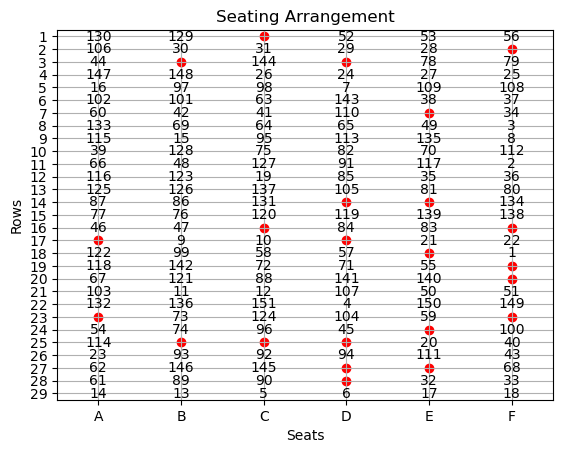

In [ ]:
# Define the dimensions of the airplane
number_of_rows = 29
seats_per_row = 6

# Define the seating arrangement
seating_arrangement = seating_arrangement

# Create a plot
fig, ax = plt.subplots()

# Plot the seating arrangement
for seat, Passengers in seating_arrangement.items():
    ax.text(seat[1], seat[0], Passengers, ha='center', va='center')

# Mark positions without passengers
for i in range(1, number_of_rows + 1):
    for j in range(1, seats_per_row + 1):
        if (i, j) not in seating_arrangement:
            ax.scatter(j, i, color='red')

# Set the limits and labels of the plot
ax.set_xlim(0.5, seats_per_row + 0.5)
ax.set_ylim(0.5, number_of_rows + 0.5)
ax.set_xticks(range(1, seats_per_row + 1))
ax.set_yticks(range(1, number_of_rows + 1))
ax.set_xticklabels([chr(65 + i) for i in range(seats_per_row)]) # permet de générer les lettres A,B,C,D,E,F grâce à chr()
ax.set_yticklabels(range(1, number_of_rows + 1))
ax.grid(True)

# Add labels and title
plt.xlabel('Seats')
plt.ylabel('Rows')
plt.title('Seating Arrangement')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to match the plane layout
plt.show()


In [ ]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()

In [ ]:
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[i]

In [ ]:
data1 = [['Empty' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, seats_per_row + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passagers[k]['transit']]
                else:
                    data2[i-1][j-4] = k
                    if Passagers[k]['transit']!=float('inf'): colors2[i-1][j-4] = color_transit[Passagers[k]['transit']]

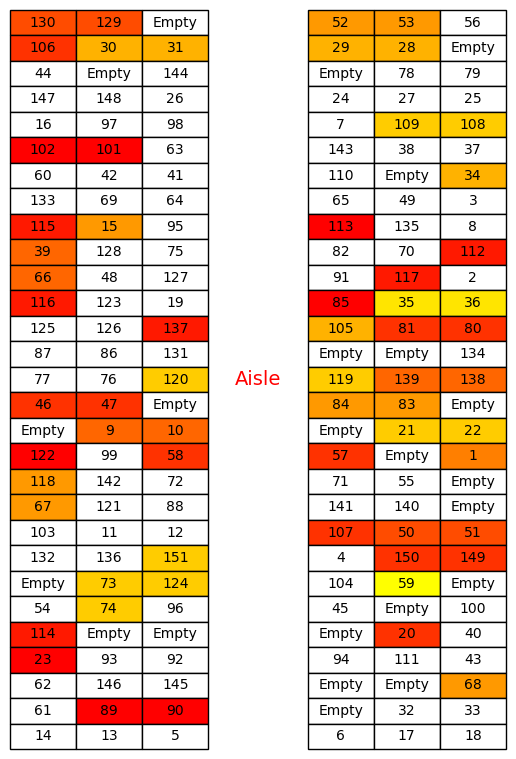

In [ ]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Représentation Groupes

In [ ]:
def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

In [99]:
graduation = generate_random_colors(len(Groups))
indices_groups=list(Groups.keys())
color_group = {indices_groups[i-1]: graduation[i-1] for i in range(1, len(Groups)+1)}

In [100]:
data1 = [['Empty' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, seats_per_row + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passagers[k]['group']]
                else:
                    data2[i-1][j-4] = k
                    if Passagers[k]['group'] in color_group: colors2[i-1][j-4] = color_group[Passagers[k]['group']]

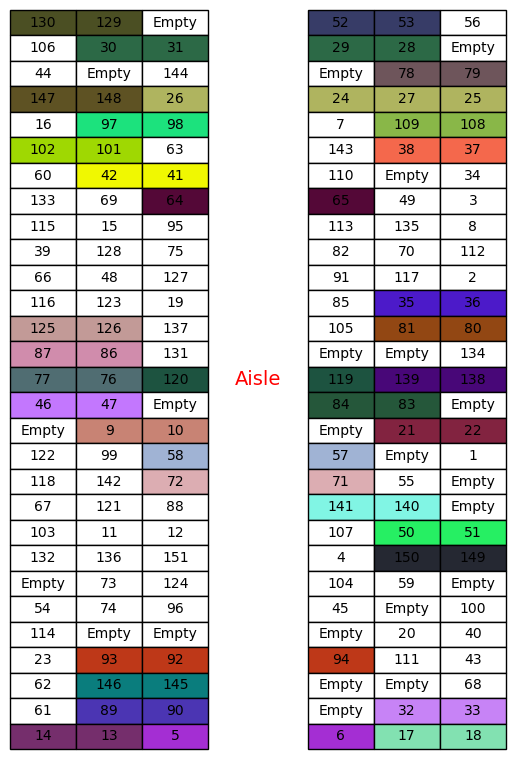

In [101]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()